# Proof of Concept (PoC)

Building QMARL with entangled agents.

In [37]:
import cirq
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Any, Callable

In [38]:
## Functions to create various entangled input states.

def entangle_agents_phi_plus(qubits, d: int, n: int):
    """Entangles via $\\phi+$."""

    # Entangle the input qubits.
    for i in range(d):
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])


def entangle_agents_psi_plus(qubits, d: int, n: int):
    """Entangles via $\\psi+$."""

    # Entangle the input qubits.
    for i in range(d):
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.X(qubits[(j+1)*d + i])
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])

In [39]:
def agent_policy(
    qubits: list,
    thetas: np.ndarray = None,
    return_thetas: bool = False,
    ):
    """Agent RL policy circuit."""
    d = len(qubits) # Dimension of qubits.
    
    if thetas is None:
        thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))

    def yield_circuit():
        for i in range(d):
            yield [
                cirq.Rx(rads=thetas[i][0])(qubits[i]),
                cirq.Ry(rads=thetas[i][1])(qubits[i]),
                cirq.Rz(rads=thetas[i][2])(qubits[i]),
                ]
        for i in range(d-1):
            yield cirq.CNOT(qubits[i], qubits[i + 1])
            
    if return_thetas:
        return yield_circuit(), thetas
    else:
        return yield_circuit()

In [40]:
def build_rl_system_circuit(
    d: int, 
    n: int, 
    entangle_fn: Callable[[list, int, int], Any] = None,
    policy_fn: Callable[[list, int, int], Any] = agent_policy,
    meas_key_all: str = 'all',
    meas_key_prefix_agent: str = 'agent',
    return_qubits: bool = False,
    ) -> cirq.Circuit:
    """Constructs an RL circuit representing the entire system (all agents).

    Args:
        d (int): Qubit dimension for each agent.
        n (int): Number of agents.
        entangle_fn (Callable[[list, int, int], Any], optional): Function that entangles qubits within the entire system input register (across all agents). Defaults to None, which means no operation (i.e., all zero state).
        policy_fn (Callable[[list, int, int], Any], optional): Function that applies a policy circuit for a specific agent. Defaults to None, which means no operation (i.e., all zero state).
        meas_key_prefix_agent (str, optional): Agent measurement key prefix. Defaults to 'agent', which means 'agent0', 'agent1', etc.
        return_qubits (bool, optional): Returns list of qubits after circuit.

    Returns:
        cirq.Circuit: _description_
    """
    qubits = cirq.LineQubit.range(d * n)
    circuit = cirq.Circuit()
    if entangle_fn is not None:
        # circuit.append(entangle_agents_phi_plus(qubits, d, n))
        circuit.append(entangle_fn(qubits, d, n))
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        # circuit.append(agent_policy(qubits, d, aidx)) # Policy circuit.
        # print(f"{len(qubits[qidx:qidx+d])=}")
        circuit.append(policy_fn(qubits[qidx:qidx+d])) # Policy circuit.
        circuit.append(cirq.measure(qubits[qidx:qidx+d], key=f"{meas_key_prefix_agent}{aidx}")) # Measure agent qubits.
    circuit.append(cirq.measure(qubits, key=meas_key_all)) # Store measurement of 
    if return_qubits:
        return circuit, qubits
    else:
        return circuit

In [41]:
def plot_state_histogram_all(samples, axis, d: int, n: int, key: str = 'all', color: str|tuple[float, float, float] = None):
    hist_all = samples.histogram(key=key)
    df_hist_all = pd.DataFrame.from_records([hist_all], columns=list(range(2**(d*n)))).melt(value_vars=list(range(2**(d*n)))).rename(columns={'variable': 'qubit state', 'value': 'result count'})
    if color is None:
        color = sns.color_palette()[0]
    sns.barplot(df_hist_all, x='qubit state', y='result count', ax=axis, color=color)
    ctr = samples.histogram(key=key)
    mean = np.mean([v for k, v in ctr.items()])
    std = np.std([v for k, v in ctr.items()])
    axis.axhline(y=mean, color='red', linestyle='--', label='mean')
    axis.axhline(y=mean+std, color='green', linestyle='--', label='mean+std')
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    axis.xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
    axis.legend()
    return axis


def plot_state_histogram_agents(samples, axis, d: int, n: int, key_prefix: str = 'agent', colors: list[str|tuple[float,float,float]] = None):
    hist_agents = [samples.histogram(key=f"{key_prefix}{k}") for k in range(n)]
    df_hist_agents = pd.DataFrame.from_records(hist_agents, columns=list(range(2**d)))
    df_hist_agents = df_hist_agents\
        .rename_axis(index='agent')\
        .reset_index()\
        .melt(id_vars='agent', value_vars=list(range(2**d)))\
        .rename(columns={'variable': 'qubit state', 'value': 'result count'})
    if colors is None:
        colors = sns.color_palette()[1:] # Remove first one because it is assumed to be reserved for the "all" plot.
    sns.barplot(df_hist_agents, x='qubit state', y='result count', hue='agent', ax=axis, palette=colors)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    axis.xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d}b}")
    return axis

In [42]:
d_qubits = 2 # Number of qubits (dimension) for each agent.
n_agents = 2 # Number of agents.

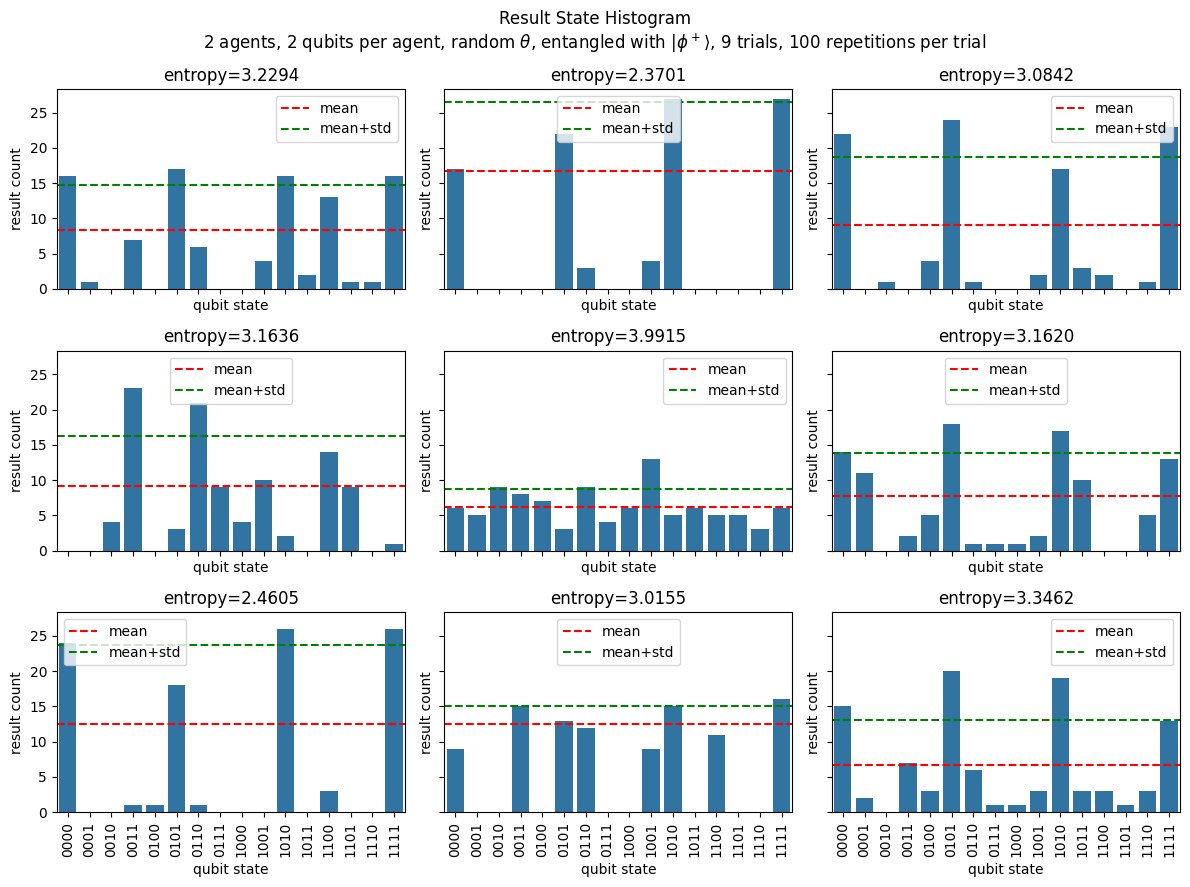

In [43]:

def test_entangled_phi_plus(d: int, n: int, repetitions: int = 100):

    fig, axs = plt.subplots(3, 3, figsize=(12, 9), sharex=True, sharey=True)
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, random $\\theta$, entangled with $|\phi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_circuits):
        circuit = build_rl_system_circuit(
            d=d,
            n=n,
            entangle_fn=entangle_agents_phi_plus,
            policy_fn=agent_policy,
            meas_key_all='all',
            meas_key_prefix_agent='agent',
        )
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        plot_state_histogram_all(samples, axs[i], d, n, key='all')
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_phi_plus(d_qubits, n_agents);

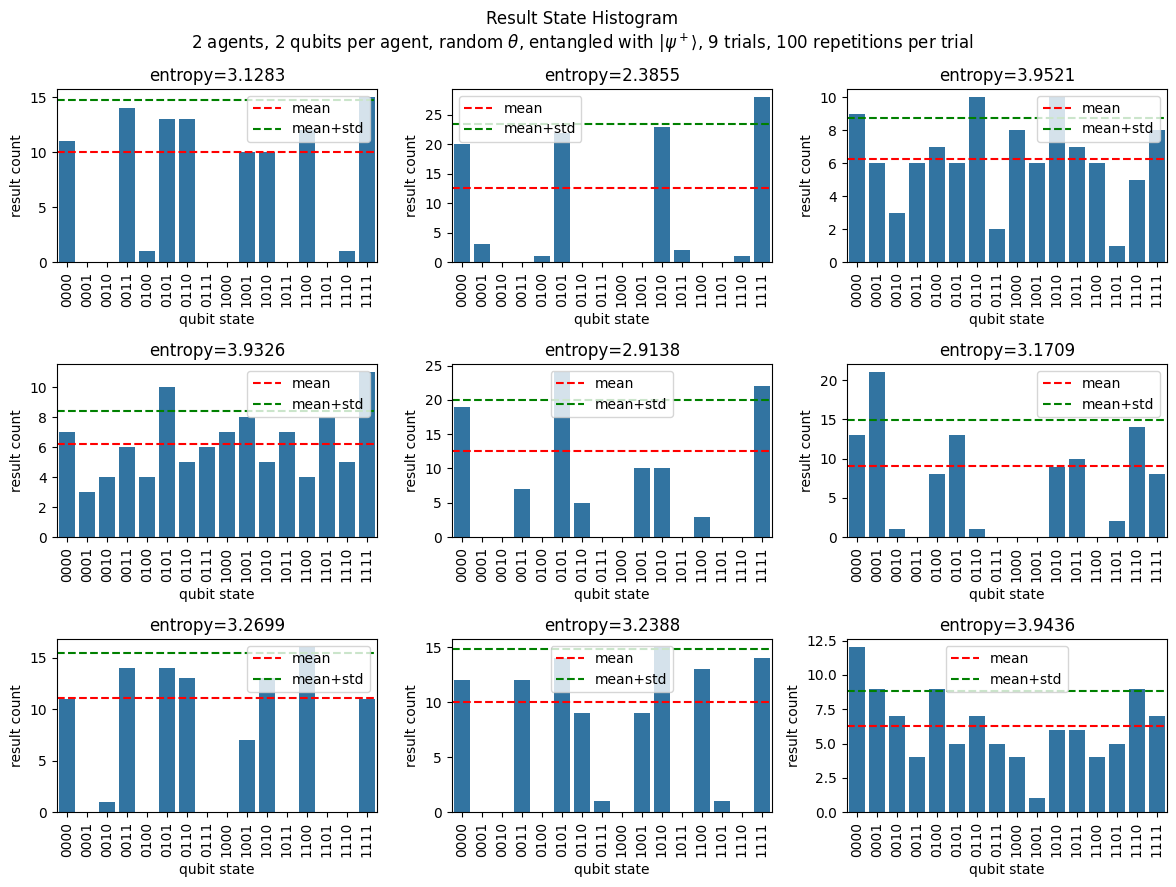

In [44]:

def test_entangled_psi_plus(d: int, n: int, repetitions: int = 100):

    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, random $\\theta$, entangled with $|\psi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_circuits):

        circuit = build_rl_system_circuit(
            d=d,
            n=n,
            entangle_fn=entangle_agents_psi_plus,
            policy_fn=agent_policy,
            meas_key_all='all',
            meas_key_prefix_agent='agent',
        )
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        plot_state_histogram_all(samples, axs[i], d, n, key='all')
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_psi_plus(d_qubits, n_agents);

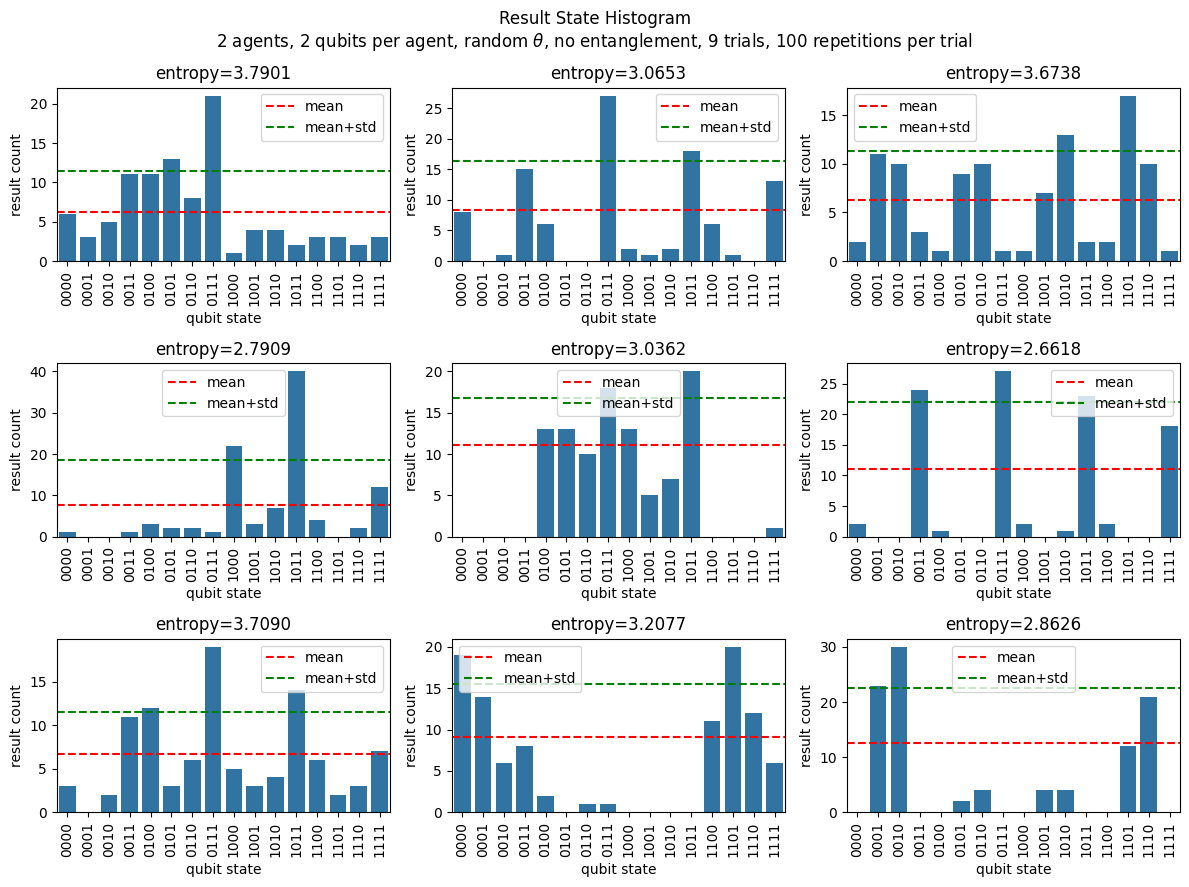

In [45]:

def test_no_entangled(d: int, n: int, repetitions: int = 100):

    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, random $\\theta$, no entanglement, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_circuits):
        circuit = build_rl_system_circuit(
            d=d,
            n=n,
            entangle_fn=None,
            policy_fn=agent_policy,
            meas_key_all='all',
            meas_key_prefix_agent='agent',
        )
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        plot_state_histogram_all(samples, axs[i], d, n, key='all')
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_no_entangled(d_qubits, n_agents);

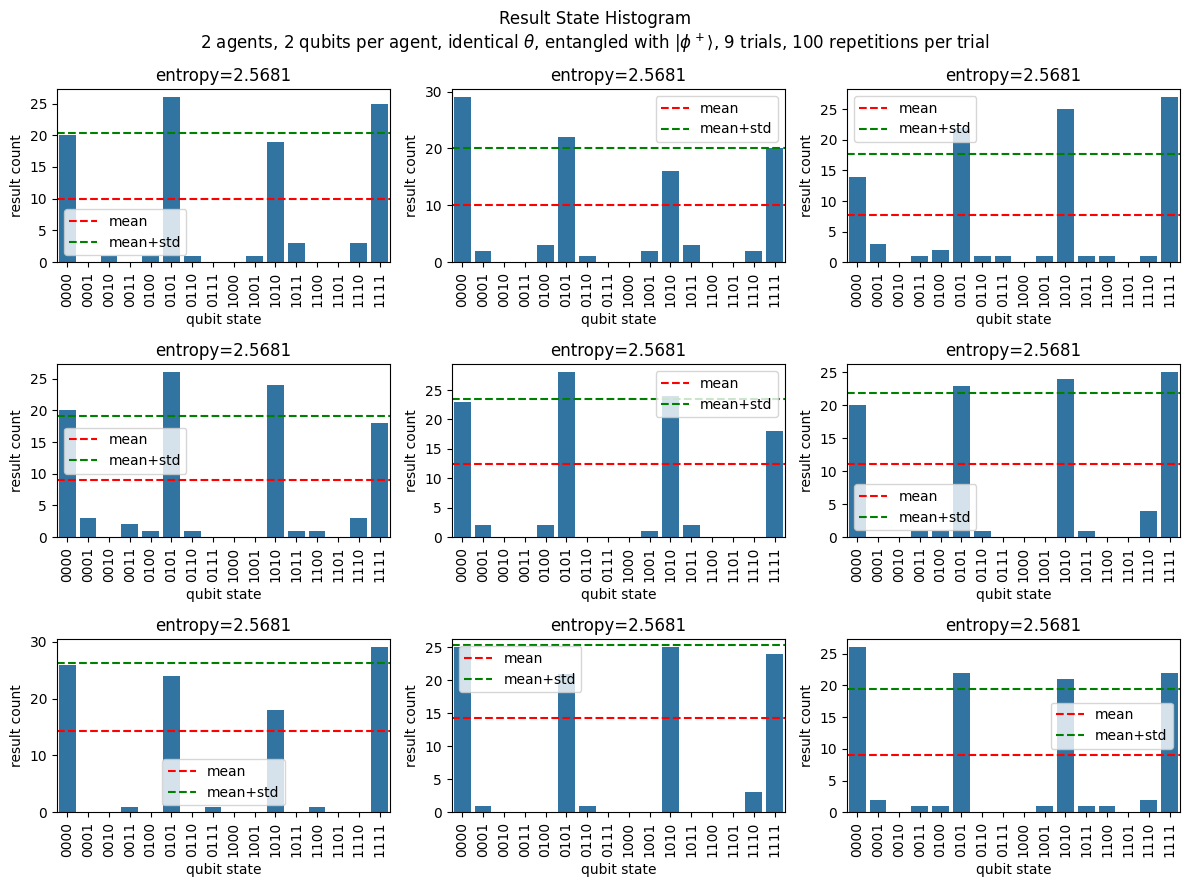

In [46]:

def test_entangled_phi_plus_identical_thetas(d: int, n: int, repetitions: int = 100):

    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, identical $\\theta$, entangled with $|\phi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()
    
    thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))

    for i in range(n_circuits):
        
        def policy(*args, **kwargs):
            return agent_policy(*args, **kwargs, thetas=thetas)
        
        circuit = build_rl_system_circuit(
            d=d,
            n=n,
            entangle_fn=entangle_agents_phi_plus,
            policy_fn=policy,
            meas_key_all='all',
            meas_key_prefix_agent='agent',
        )
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        plot_state_histogram_all(samples, axs[i], d, n, key='all')
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_phi_plus_identical_thetas(d_qubits, n_agents);

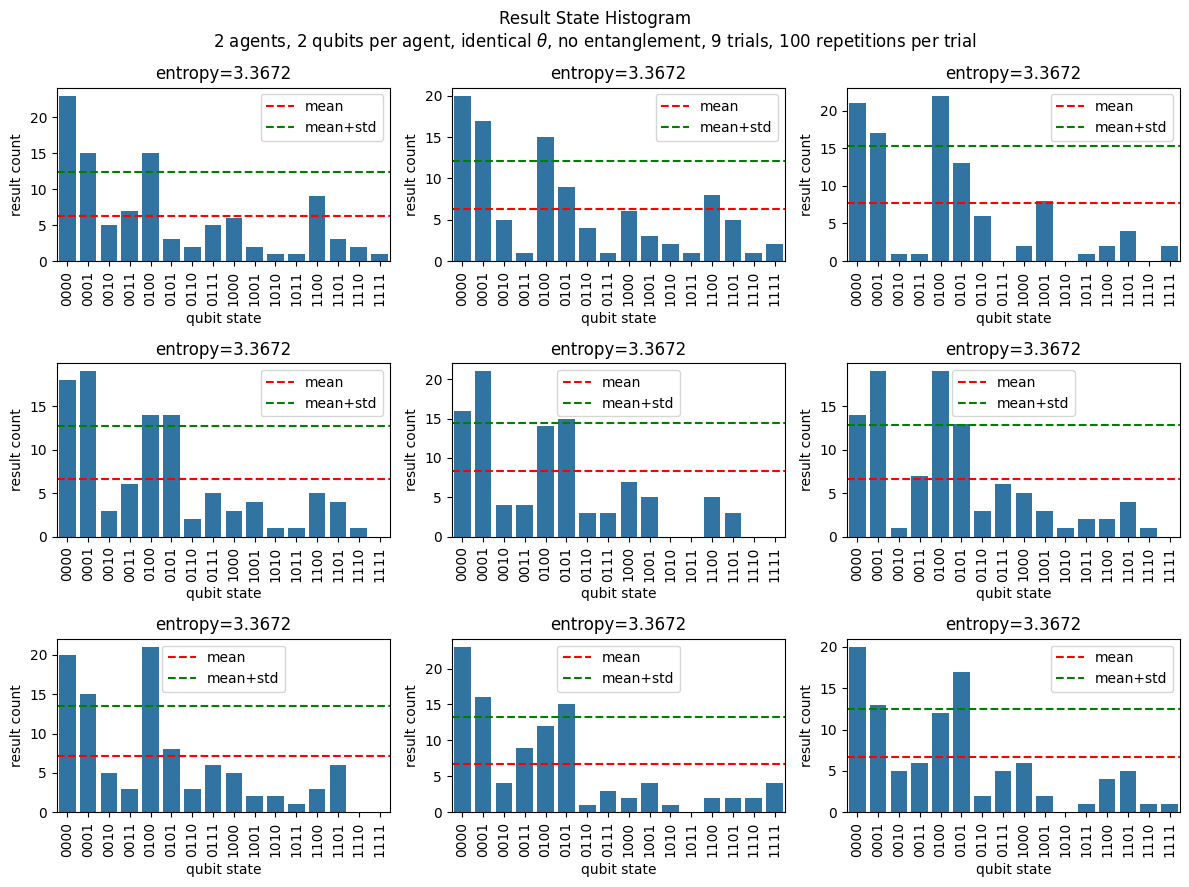

In [47]:

def test_no_entangled_identical_thetas(d: int, n: int, repetitions: int = 100):


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, identical $\\theta$, no entanglement, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()
    
    thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))

    for i in range(n_circuits):
        
        def policy(*args, **kwargs):
            return agent_policy(*args, **kwargs, thetas=thetas)

        circuit = build_rl_system_circuit(
            d=d,
            n=n,
            entangle_fn=None,
            policy_fn=policy,
            meas_key_all='all',
            meas_key_prefix_agent='agent',
        )
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        plot_state_histogram_all(samples, axs[i], d, n, key='all')
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_no_entangled_identical_thetas(d_qubits, n_agents);

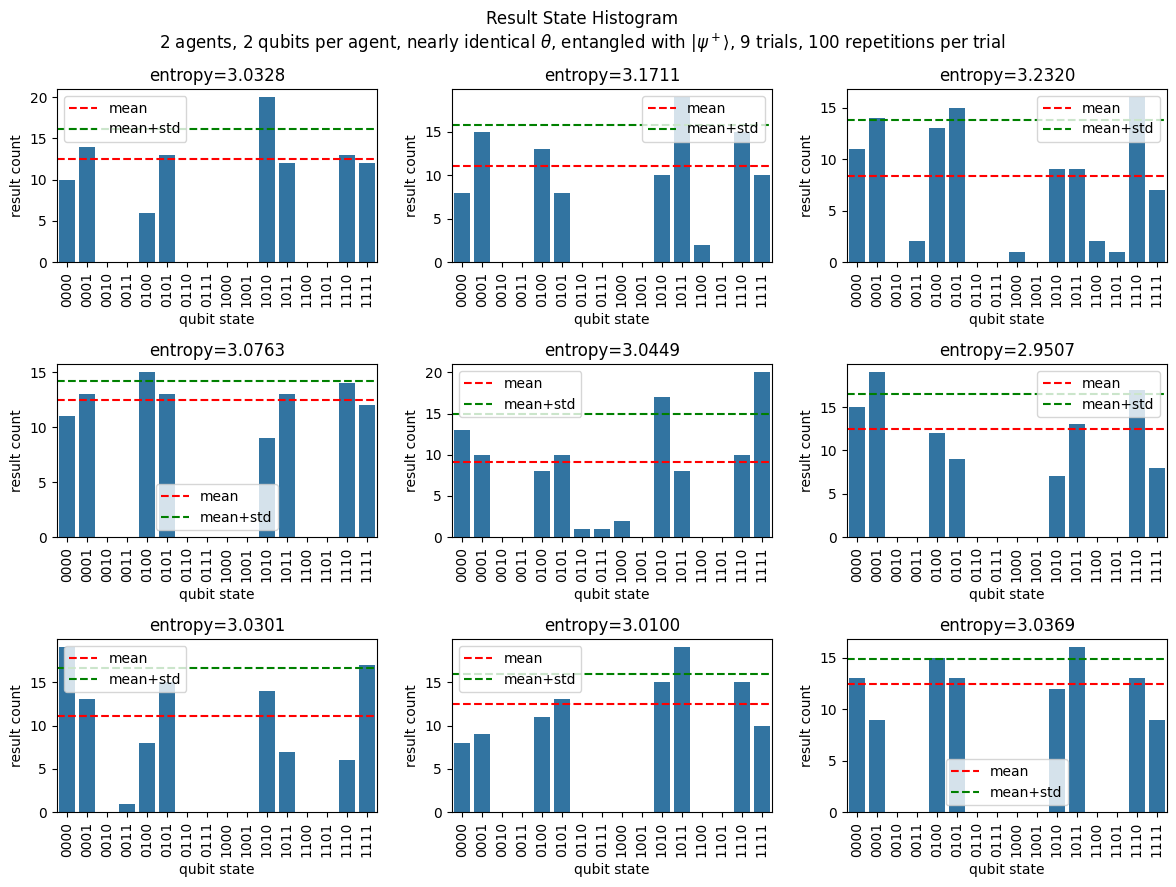

In [48]:

def test_entangled_phi_plus_approx_thetas(d: int, n: int, repetitions: int = 100):

    # qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, nearly identical $\\theta$, entangled with $|\psi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()
    
    thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))

    for i in range(n_circuits):
        
        def policy(*args, **kwargs):
            thetas_offset = np.random.uniform(low=0., high=0.5, size=(d, 3,))
            return agent_policy(*args, **kwargs, thetas=thetas+thetas_offset)

        circuit = build_rl_system_circuit(
            d=d,
            n=n,
            entangle_fn=entangle_agents_psi_plus,
            policy_fn=policy,
            meas_key_all='all',
            meas_key_prefix_agent='agent',
        )
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        plot_state_histogram_all(samples, axs[i], d, n, key='all')
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_phi_plus_approx_thetas(d_qubits, n_agents);

len(qubits[qidx:qidx+d])=2
len(qubits[qidx:qidx+d])=2


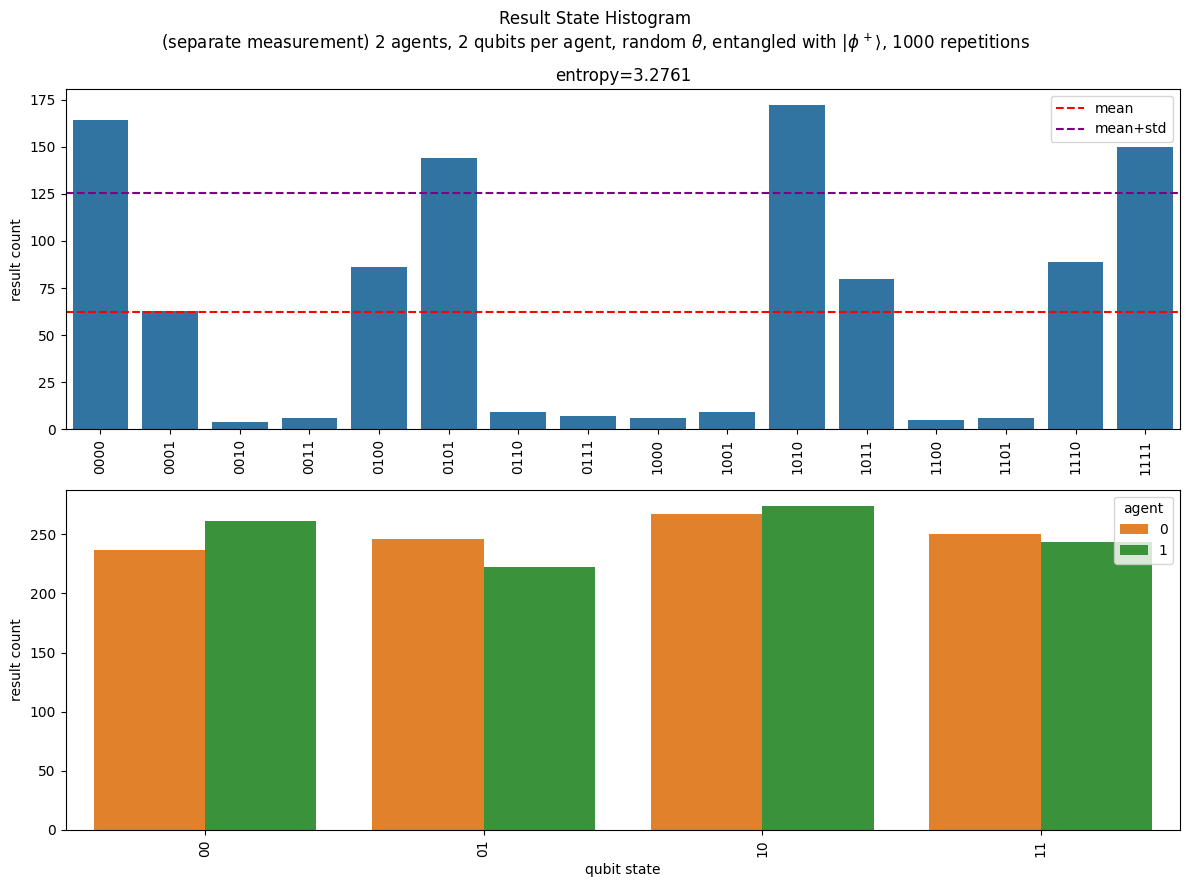

In [13]:
## Try separate measurements for each agent.

def test(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)

    w, h = 1, 2
    # fig, axs = plt.subplots(w, h, figsize=(12, 9))
    fig, axd = plt.subplot_mosaic(mosaic="A;B", figsize=(12, 9), layout='constrained')
    # axs = axs.flatten()
    
    # fig = plt.figure(figsize=(12, 9))
    # grid_outer = gsp.GridSpec(w, h, figure=fig, wspace=0.2, hspace=0.2)
    
    
    fig.suptitle(f'Result State Histogram\n(separate measurement) {n} agents, {d} qubits per agent, random $\\theta$, entangled with $|\phi^+\\rangle$, {repetitions} repetitions')

    sim = cirq.Simulator()


    circuit = build_rl_system_circuit(
        d=d,
        n=n,
        entangle_fn=entangle_agents_phi_plus,
        policy_fn=agent_policy,
        meas_key_all='all',
        meas_key_prefix_agent='agent',
    )
    # circuit = cirq.Circuit()
    # circuit.append(entangle_agents_phi_plus(qubits, d, n))
    # for aidx in range(n):
    #     circuit.append(agent_policy(qubits, d, aidx)) # Policy circuit.
    #     circuit.append(measure_agent(qubits, d, aidx)) # Measure agent qubits.
    # circuit.append(cirq.measure(qubits, key='all')) # Store measurement of entire system (all agents, for bookkeeping purposes).
    
    
    # print(circuit)
    
    rho = cirq.final_density_matrix(circuit)
    entropy = cirq.von_neumann_entropy(rho)
    
    samples = sim.run(circuit, repetitions=repetitions)

    plot_state_histogram_all(samples, axd['A'], d, n, key='all')
    plot_state_histogram_agents(samples, axd['B'], d, n, key_prefix='agent')

    axd['A'].set_title(f"{entropy=:.4f}")
    axd['A'].set_xlabel('')

    fig.tight_layout()

test(d_qubits, n_agents, repetitions=1000);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


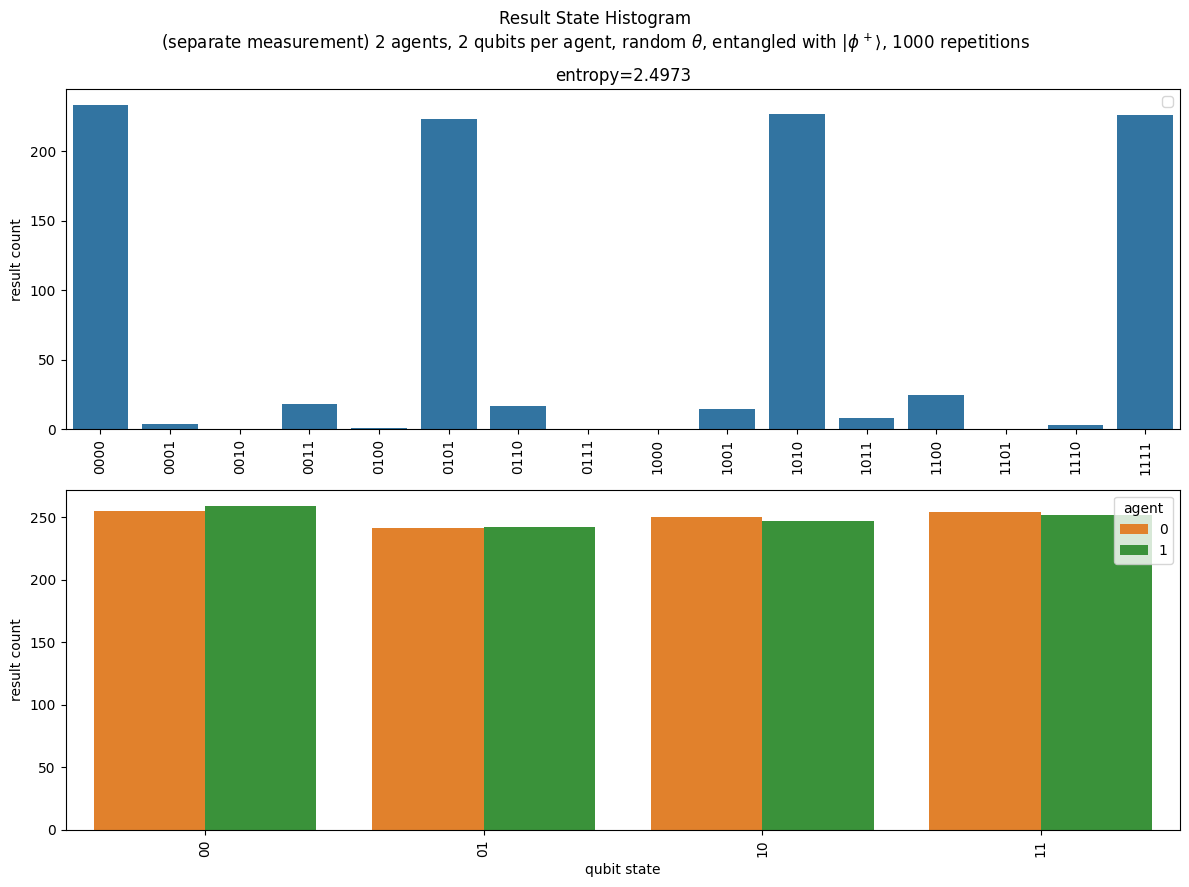

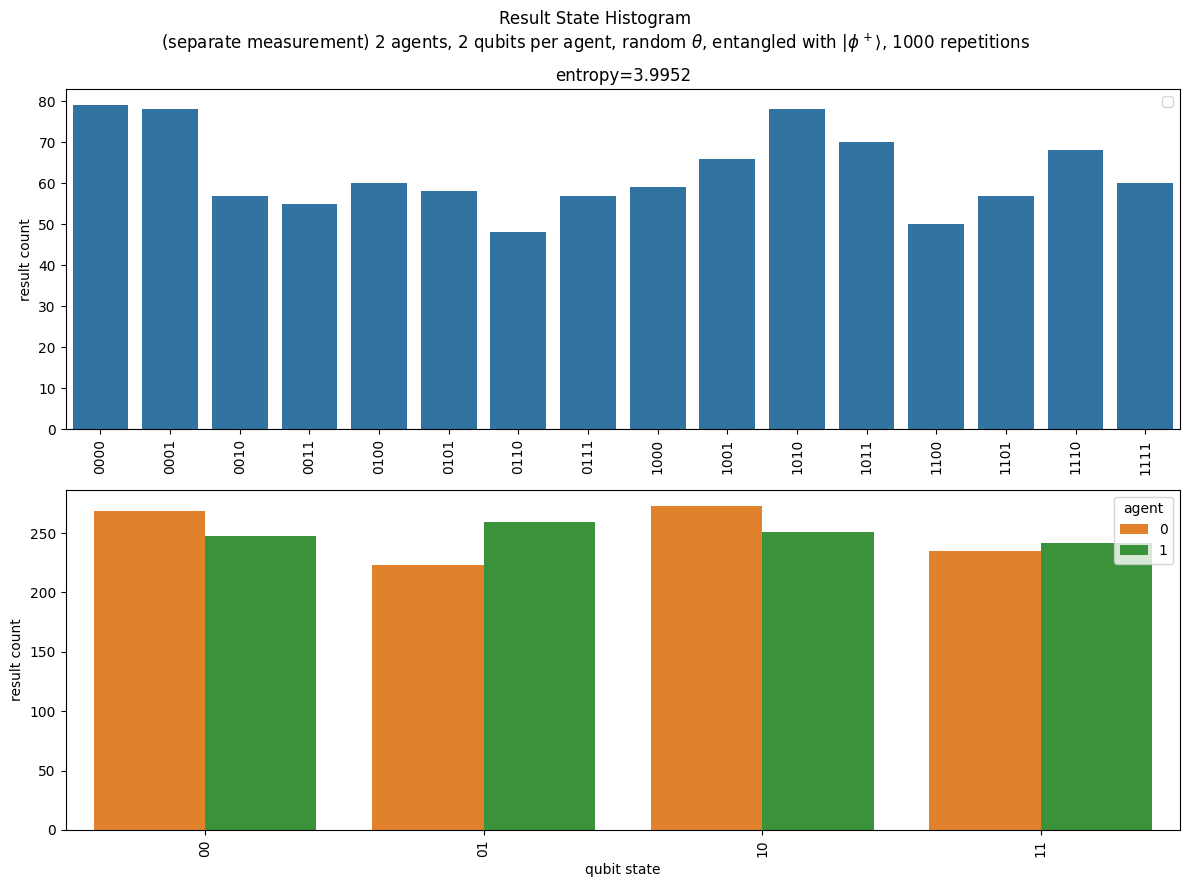

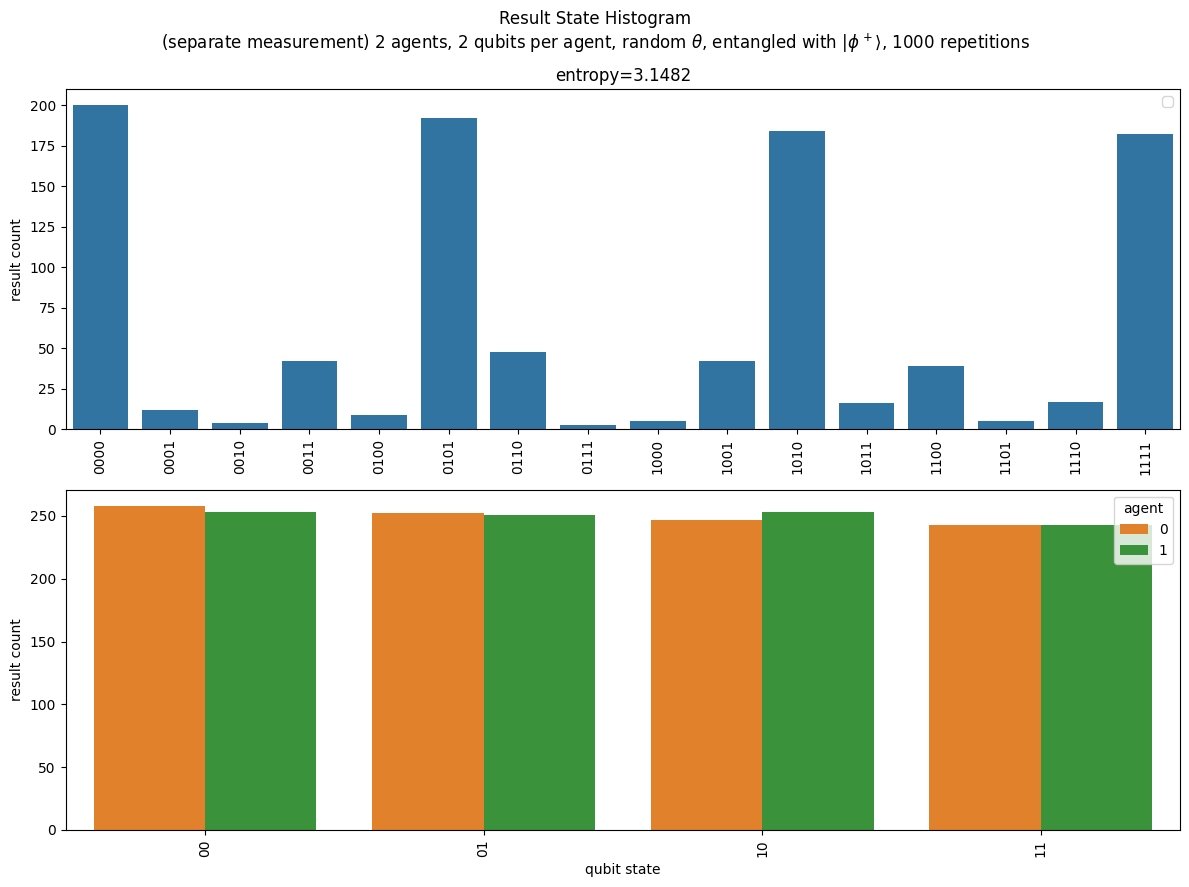

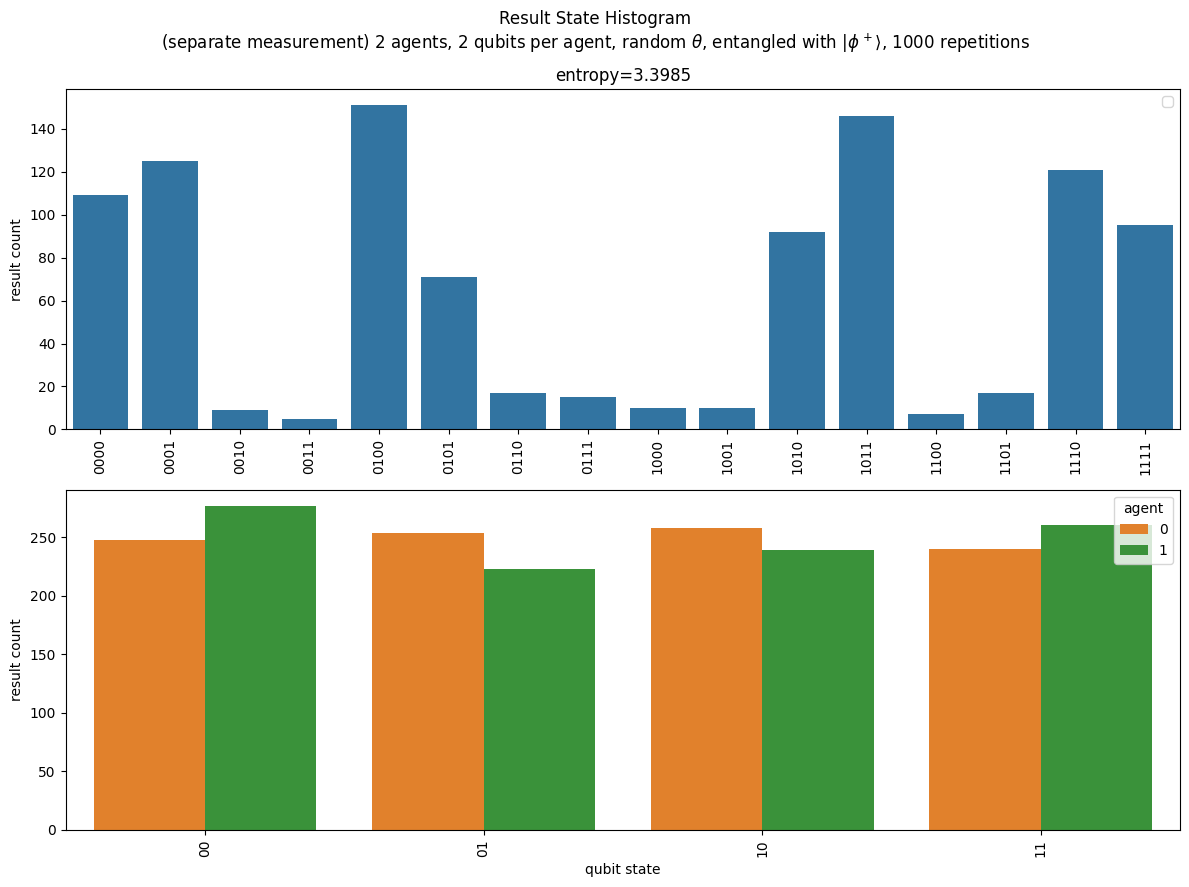

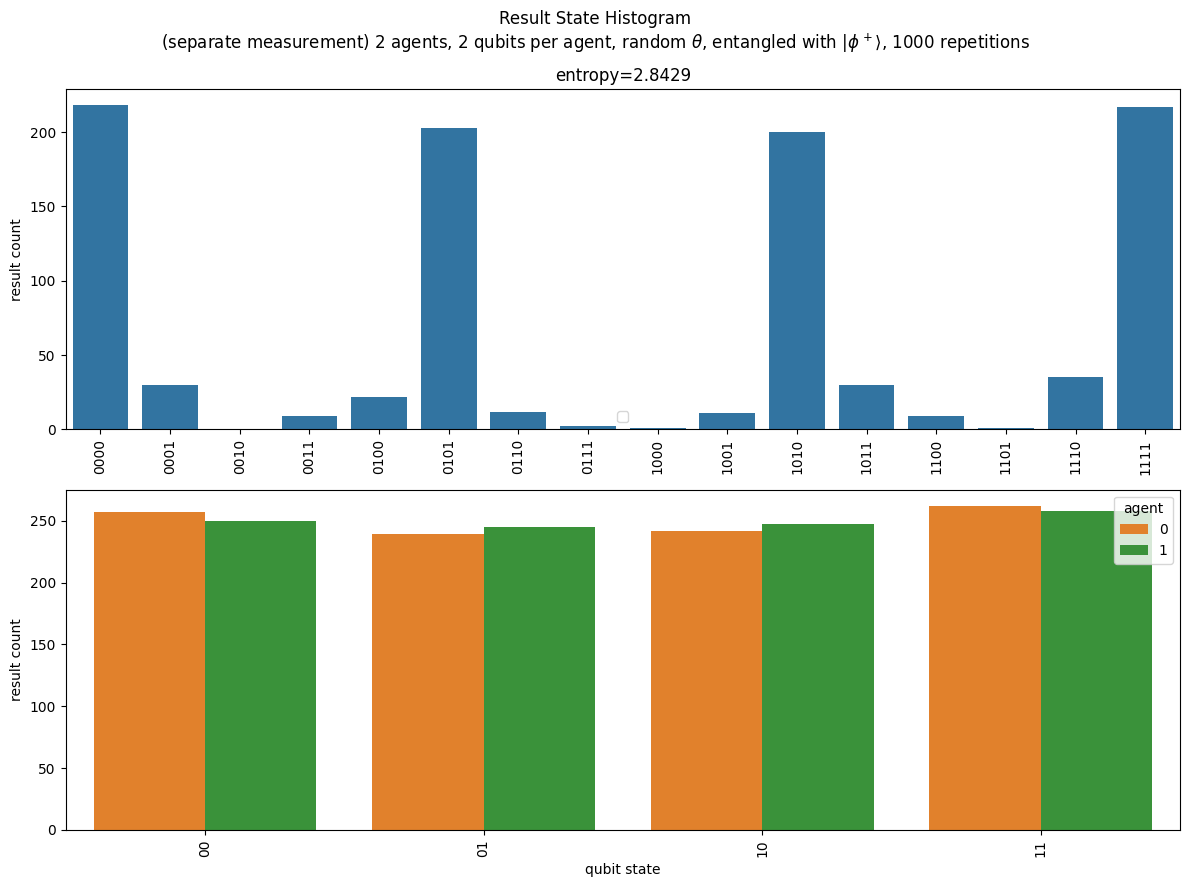

In [130]:
for _ in range(5):
    test(d_qubits, n_agents, repetitions=1000);

In [125]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]